# An Analysis of the Santa Barbara and Ventura Thomas Fire  

This analysis was conducted using data from the Environmental Protection Agency (EPA) as well as Landsat 8 satellite data to analyze trends and display the effects of the Thomas Fire that occurred on December 4th in 2017. The year of 2017 was comprised of multi-year droughts, high winds, and triple digit temperatures. Similarly, the prior winter, rain left a thick landscape of grass and brush that then dried over the record hot summer providing acres and acres of fuel. As a result, the Thomas Fire burned a total of 281,893 acres of land  and resulted in an increased AQI categorized as unhealthy and hazardous in Santa Barbara and Ventura. 

For further questions regarding the analysis, dataset, and workflow, the git hub link provided below will grant access to this 

**Github Repositorty**: 
 https://github.com/kateebeckerr/ThomasFire_Analysis.git

## Dataset Descriptors

1. **Daily air quality index data from 2017 and 2018**

(https://www.airnow.gov/aqi/aqi-basics/)

(https://www.epa.gov)

(https://www.epa.gov/outdoor-air-quality-data)



2. **A simplified collection of bands (red, green, blue, near-infrared and shortwave infrared) from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data, collected by the Landsat 8 satellite**

(https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2)



3. **A shapefile of fire perimeters in California during 2017**

(https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about)



## Import Necessary Libraries and Functions

In [33]:
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd 
import rioxarray as rioxr

from shapely.geometry import box
from shapely.geometry import Polygon
from shapely.geometry import Point

## Data Import

In [34]:
#Dataset 1
#Read air quality data for the year of 2017 from the EPA website
#The data is in a compressed ZIP file and is read in 
aqi_2017 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip')
aqi_2017

#Dataset 2
#Read air quality data for the year of 2018 from the EPA website
#The data is in a compressed ZIP file and is read in 
aqi_2018 = pd.read_csv('https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip')
aqi_2018

#Dataset 3
#Reads the Landsat 8 satellite data for the data (2018-01-26) from a NetCDF file 
#Constructs a file path and places the .nc data within your current working directory and names landsat8 
landsat8 = os.path.join(os.getcwd(),'data/landsat8-2018-01-26-sb-simplified.nc')
landsat = rioxr.open_rasterio(landsat8) #Opens the raster data 
landsat

#Dataset 4
#Reads the shapefile for California fire perimeters in 2017 from the file path in your working directory 
california = gpd.read_file('data/California_Fires/California_Fire_Perimeters_2017.shp')

#### Prior to data wrangling, a series of exploratory analysis took places such as the analysis of CRS', data structure, data type, summary statistics, geometries, geographical context, etc.. All of which occured using the **Numpy** package in python.

## Data Wrangling 

### California Shapefile
Only want to include the geometries associated with the Thomas Fire

In [35]:
#filters the rows in the california dataframe where the fire_name column is equal to thomas and creates a new dataframe called thomas_Fire containing only the filtered rows  
thomas_fire = california[california['FIRE_NAME'] == 'THOMAS']

### Landsat

For further analysis this step is necessary to effectively process raster data. This is done to clean up unnecessary information in the dataset, especially since the analysis is not based on bands. Similarily, it simplifies the structure of the data, especially when working with a single-band raster. This kind of data preprocessing is common in geospatial analysis workflows to ensure data consistency and relevance to the study area.

In [36]:
# removes length 1 dimension (band) and prints
landsat = landsat.squeeze()

# remove coordinates associated to band and prints 
landsat = landsat.drop('band')

### AQI

In [37]:
aqi = pd.concat([aqi_2017, aqi_2018]) #combining the two dataframes from 2017 and 2018
#10 columns and 654338 rows, the concat worked 

# re-assign column names - .str.lower() makes them lower case for better formatting 
aqi.columns = aqi.columns.str.lower()

# re-assign column names again - .str.replace(' ','_') replaces the space for _
aqi.columns = aqi.columns.str.replace(' ','_')

aqi_sb = aqi.loc[aqi.county_name == "Santa Barbara"] #creates a new dataframe, aqi_sb, with data from county = santa barbara only 
aqi_sb = aqi_sb.drop(columns = ['state_name', 'county_name', 'state_code', 'county_code']) #drops these columns from dataframe 

aqi_sb.date = pd.to_datetime(aqi_sb.date) #converts date column to datetime64 data type 
aqi_sb = aqi_sb.set_index('date') #sets the date column as the index of the df for time series analysis 

## Analyzing Time Series Data

A moving five-day average employed to create a rolling view of the air quality data.This provides a more stable and representative measure of air quality over short periods. It's also relevant to capture daily variations in order to analyze the overall trend in air quality levels over our time frame of interest.

In [38]:
#five_day_average = aqi_sb.rolling('5D').mean() #rollign method is used to create a rolling view of the df with a specified window size, here it is a 5 day window (average of values in previous five days for corresponding date)  
aqi_sb['five_day_average'] = aqi_sb['aqi'].rolling('5D').mean() 

## Constructing a True Color Image

In order to turn the landsat data into an image specific bands (red, green, blue) are selected from the Landsat dataset, converted into an xarray DataArray, and then visualized using matplotlib. The resulting plot will show a color representation of the Landsat image, where different colors correspond to different reflectance values in the selected bands.

***Note: (robust = TRUE)*** 
The (robust = TRUE) is important to include for it essentially trims a certain percentage of the highest and lowest pixel values before determining the color scale range. This trimming is done to exclude extreme values that might disproportionately affect the color scale. 

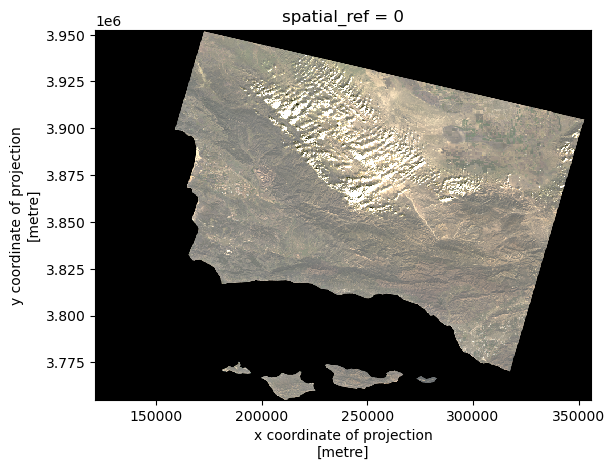

In [39]:
#transforming the geometries in the thomas_fire dataframe to a new crs specified by the landsat data 
thomas_fire = thomas_fire.to_crs(landsat.rio.crs)

#indexing the landsat variable to select the three bands red, green, and blue
#converts the bands into an xarray data array and displays the true color image 
landsat[["red", "green", "blue"]].to_array().plot.imshow(robust = True)

## Constructing a False Color Image 

This image selects the bands (SWIR2, NIR, Red), converting them into an xarray DataArray, and then visualizes the false image using matplotlib with robust scaling applied to enhance the visibility of features in the data. Using bands like Short-Wave Infrared 2 (SWIR2), Near-Infrared (NIR), and Red instead of Red, Green, and Blue (RGB) bands can provide advantages in remote sensing applications. Some common applications for the use of these bands is to dissect vegetation monitoring, water content and quality, mineral identification, urban studies ,and atmospheric penetration. 

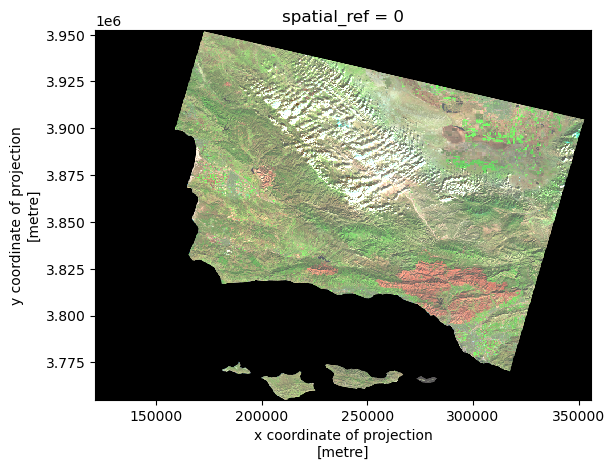

In [40]:
#selects the three bands from the landsat 8 image which are swir22(short wave infrared), nir08(near-infrared), and red 
#converts the selected bands into an xarray dataarray and displays the false color image 
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust = True)

## Map

### The Air Quality and Land Effects of the Thomas Fire on Santa Barbara, CA 

<Axes: title={'center': 'spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

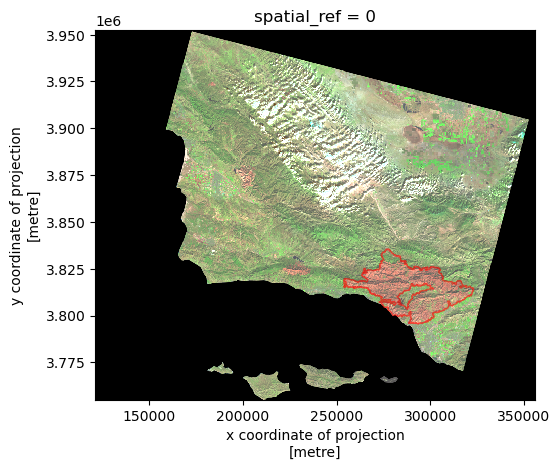

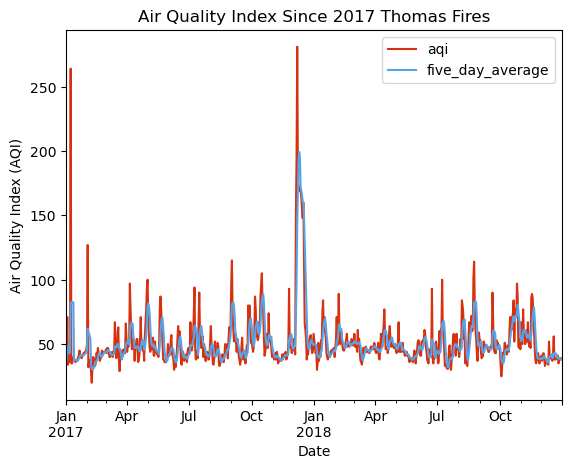

In [45]:
aqi_sb = aqi_sb.reset_index() #removes the date from the current index to plot dates on the x axis 

fig, ax = plt.subplots()

ax1 = aqi_sb.plot(x = 'date', 
        y =['aqi', 'five_day_average'],
        title = 'Air Quality Index Since 2017 Thomas Fires',
        xlabel='Date',
        ylabel='Air Quality Index (AQI)',        
        color = {'aqi':'#d73110',
                 'five_day_average': '#56a4e8'
                 }
        )

landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(ax=ax, robust = True) #plots a false color image using the landsat bands swir22, nir08, and red on the axis ax 
thomas_fire.plot(ax=ax, alpha=0.6, edgecolor = 'red', color = 'none')



## Findings 

This analysis was conducted to show the effects of the December 4th, 2017 Thomas Fire on the environmental conditions of Santa Barbara, California. As a result of this fire, a large area of land was scorched and the air quality reached high levels deemed as unhealthy. 